In [2]:
# DEMO CELL 1: Mount Google Drive and Import Libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil # For potentially cleaning up the extraction directory
import timm # For DeiT model definition

Mounted at /content/drive


In [3]:
# DEMO CELL 2: Define Paths and Constants
# !!! ADJUST THESE PATHS ACCORDING TO YOUR DRIVE STRUCTURE !!!
MODEL_PATH_DEMO = '/content/drive/MyDrive/CornLeaf_DeiT.pth' # Path to saved DeiT .pth model state_dict
TEST_ZIP_PATH_DEMO = '/content/drive/MyDrive/CS180 Project Test Sets/corn_test.zip' # Path to corn_test.zip

# Paths for extracting the test images
EXTRACT_TO_PATH_DEMO = '/content/corn_test_extracted_demo/'
TEST_IMAGE_FOLDER_DEMO = os.path.join(EXTRACT_TO_PATH_DEMO, 'corn_test')

# Model input image dimensions
IMG_SIZE_DEMO = 224
CLASS_NAMES_DEMO = ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'] # Must match training
NUM_CLASSES_DEMO = len(CLASS_NAMES_DEMO)

In [4]:
# DEMO CELL 3: Unzip the Test Set (Self-contained for the demo)
if os.path.exists(TEST_IMAGE_FOLDER_DEMO):
    print(f"Test images folder already exists at {TEST_IMAGE_FOLDER_DEMO}. Using existing files.")
else:
    if os.path.exists(EXTRACT_TO_PATH_DEMO):
        shutil.rmtree(EXTRACT_TO_PATH_DEMO)
    os.makedirs(EXTRACT_TO_PATH_DEMO, exist_ok=True)

    if os.path.exists(TEST_ZIP_PATH_DEMO):
        print(f"Extracting test images from {TEST_ZIP_PATH_DEMO}...")
        with zipfile.ZipFile(TEST_ZIP_PATH_DEMO, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_TO_PATH_DEMO)
        print(f"Test images extracted to {TEST_IMAGE_FOLDER_DEMO}")
    else:
        print(f"ERROR: Test ZIP file not found at {TEST_ZIP_PATH_DEMO}. Please check the path.")
        raise FileNotFoundError(f"Test ZIP file not found at {TEST_ZIP_PATH_DEMO}")

if os.path.exists(TEST_IMAGE_FOLDER_DEMO):
    print(f"Found {len(os.listdir(TEST_IMAGE_FOLDER_DEMO))} files/folders in {TEST_IMAGE_FOLDER_DEMO}")
else:
    raise FileNotFoundError(f"Error: {TEST_IMAGE_FOLDER_DEMO} not found after attempting to extract.")

Extracting test images from /content/drive/MyDrive/CS180 Project Test Sets/corn_test.zip...
Test images extracted to /content/corn_test_extracted_demo/corn_test
Found 838 files/folders in /content/corn_test_extracted_demo/corn_test


In [5]:
# DEMO CELL 4: Load the Trained DeiT Model
device_demo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device_demo}")

loaded_model_demo = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=NUM_CLASSES_DEMO)
if os.path.exists(MODEL_PATH_DEMO):
    try:
        loaded_model_demo.load_state_dict(torch.load(MODEL_PATH_DEMO, map_location=device_demo))
        loaded_model_demo.to(device_demo)
        loaded_model_demo.eval() # Set model to evaluation mode
        print(f"Demo model loaded successfully from {MODEL_PATH_DEMO}")
    except Exception as e:
        print(f"Error loading demo model state_dict: {e}")
        loaded_model_demo = None # Ensure model is None if loading failed
        raise
else:
    print(f"ERROR: Model file not found at {MODEL_PATH_DEMO}. Cannot proceed with demo.")
    loaded_model_demo = None
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH_DEMO}")

Using device: cuda
Demo model loaded successfully from /content/drive/MyDrive/CornLeaf_DeiT.pth


In [6]:
# DEMO CELL 5: Preprocessing and Prediction Functions for Demo
val_transform_demo = transforms.Compose([
    transforms.Resize((IMG_SIZE_DEMO, IMG_SIZE_DEMO)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_single_image_for_demo(image_path):
    try:
        img_pil = Image.open(image_path).convert('RGB') # Load as PIL for display
        img_tensor = val_transform_demo(img_pil)
        img_tensor = img_tensor.unsqueeze(0) # Add batch dimension
        return img_tensor, img_pil # Return tensor for model, PIL for display
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

def predict_single_image_class(img_tensor):
    if img_tensor is not None and loaded_model_demo is not None:
        img_tensor = img_tensor.to(device_demo)
        with torch.no_grad():
            outputs = loaded_model_demo(img_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_class_name = CLASS_NAMES_DEMO[predicted_idx.item()]
            return predicted_class_name, confidence.item() * 100
    elif loaded_model_demo is None:
        return "Model Not Loaded", 0.0
    else:
        return "Preprocessing Error", 0.0

--- Demonstrating with image: /content/corn_test_extracted_demo/corn_test/1.jpeg ---


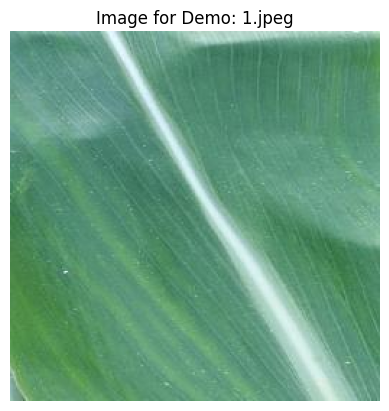


Predicted Class: Healthy
Confidence: 100.00%


In [7]:
# DEMO CELL 6: Specify Image from Test Set and Predict
# --- CHANGE 'image_filename_to_demo' FOR DEMONSTRATION ---
image_filename_to_demo = '1.jpeg'  # Example: '0.jpeg', '15.jpeg', '123.jpeg', etc.
# Ensure this filename exists in TEST_IMAGE_FOLDER_DEMO.
# --------------------------------------------------------------------------

if loaded_model_demo and os.path.exists(TEST_IMAGE_FOLDER_DEMO):
    image_path_to_demo = os.path.join(TEST_IMAGE_FOLDER_DEMO, image_filename_to_demo)

    if not os.path.exists(image_path_to_demo):
        print(f"ERROR: The specified image '{image_filename_to_demo}' was not found in '{TEST_IMAGE_FOLDER_DEMO}'.")
        print(f"Please check the filename. Available files (up to 5): {os.listdir(TEST_IMAGE_FOLDER_DEMO)[:5] if os.listdir(TEST_IMAGE_FOLDER_DEMO) else 'No files found'}")
    else:
        print(f"--- Demonstrating with image: {image_path_to_demo} ---")
        image_tensor_demo, original_image_display = preprocess_single_image_for_demo(image_path_to_demo)

        if image_tensor_demo is not None and original_image_display is not None:
            plt.imshow(original_image_display) # Display the PIL image
            plt.axis('off')
            plt.title(f"Image for Demo: {image_filename_to_demo}")
            plt.show()

            predicted_class, confidence_score = predict_single_image_class(image_tensor_demo)
            print(f"\nPredicted Class: {predicted_class}")
            print(f"Confidence: {confidence_score:.2f}%")
        else:
            print(f"Could not process the image: {image_filename_to_demo}")
elif not loaded_model_demo:
    print("Demo cannot run because the model was not loaded successfully.")
elif not os.path.exists(TEST_IMAGE_FOLDER_DEMO):
    print("Demo cannot run because the test image folder was not found or extracted correctly.")